# Validation Set 3 LTOO

In [1]:
import os
import time

import itertools
from collections import defaultdict


from openpyxl import load_workbook
import networkx as nx

##### PyBEL imports

In [2]:
import pybel
import pybel_tools as pbt

from pybel import BELGraph
from pybel.constants import RELATION, ANNOTATIONS
from pybel.dsl import Abundance, BiologicalProcess, CentralDogma, ListAbundance, Reaction
from pybel.struct import get_subgraph_by_annotation_value
from pybel.struct.summary import count_functions

pybel.get_version()

'0.13.2'

##### PathMe import 

In [3]:
from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL, PATHME_DIR
from pathme.export_utils import to_gml

##### DiffuPath import 

In [4]:
import diffupath

from diffupath.constants import DATA_DIR
from diffupath.validation_datasets_parsers import parse_set3

from diffupath.pathme_importer import get_labels_by_db_and_omic_from_pathme, get_labels_by_db_and_omic_from_graph
from diffupath.input_mapping import get_mapping, get_mapping_subsets, get_mapping_two_dim_subsets
from diffupath.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_count_and_labels_from_two_dim_dict, from_pickle, to_pickle, get_three_venn_intersections, random_disjoint_intersection_three_subsets
from diffupath.views import show_heatmap, show_venn_diagram


## 1. Load Data Set 1: Input Scores

In [5]:
dataset3_labels_by_omics = parse_set3(os.path.join(DATA_DIR, 'validation_datasets', 'set3.xlsx'))
dataset3_all_labels = get_labels_set_from_dict(dataset3_labels_by_omics)
print_dict_dimensions(dataset3_labels_by_omics, 'Dataset3 imported labels:')

Dataset3 imported labels:
Total number of metabolite: 15  
Total number of genes: 56  
Total number of micrornas: 18  
Total number of pathway: 158  
Total: 247 


In [6]:
mirnas_dataset =  dataset3_labels_by_omics['micrornas']

## 2. Load Backrgound Network and Kernel matrix

### 2.1. Import PathMeUniverse network graph

In [7]:
pathme_universe_graph_no_flatten = pybel.from_pickle(os.path.join(DATA_DIR, 'pickles', 'universe', 'pathme_universe_bel_graph_no_flatten.bel.pickle'))
pathme_universe_graph_no_flatten.summarize()
count_functions(pathme_universe_graph_no_flatten)


PathMe Universe v1.0.0
Number of Nodes: 48643
Number of Edges: 104713
Number of Citations: 7696
Number of Authors: 0
Network Density: 4.43E-05
Number of Components: 6860
Number of Warnings: 0


Counter({'Composite': 1605,
         'Abundance': 7046,
         'BiologicalProcess': 2857,
         'Complex': 9048,
         'Reaction': 13576,
         'Gene': 14511})

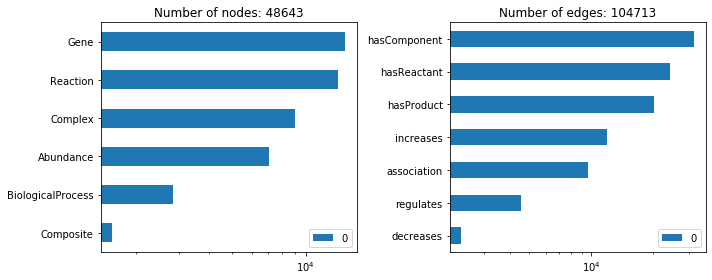

In [8]:
import matplotlib.pyplot as plt
from pybel_tools.summary import plot_summary, count_top_centrality
plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

##### Check and filter isolates / Unconnected nodes

In [9]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

6426

In [10]:
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

### 2.2. Get KEGG subgraph from PathMeUniverse graph

In [11]:
kegg_pathme_graph_no_flatten = get_subgraph_by_annotation_value(pathme_universe_graph_no_flatten, 'database', 'kegg')
kegg_pathme_graph_no_flatten.summarize()
count_functions(kegg_pathme_graph_no_flatten)

None vNone
Number of Nodes: 13162
Number of Edges: 35122
Number of Citations: 2
Number of Authors: 0
Network Density: 2.03E-04
Number of Components: 65
Number of Warnings: 0


Counter({'Composite': 1596,
         'Complex': 406,
         'Gene': 6149,
         'Abundance': 1762,
         'Reaction': 3137,
         'BiologicalProcess': 112})

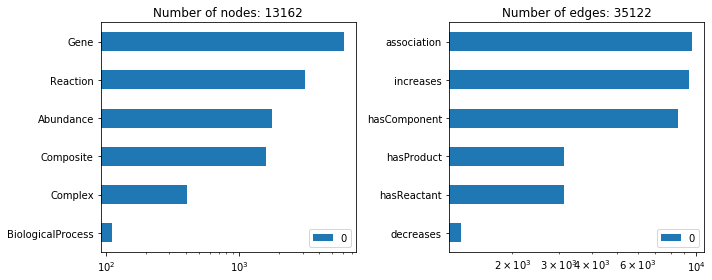

In [12]:
import matplotlib.pyplot as plt
from pybel_tools.summary import plot_summary, count_top_centrality
plot_summary(kegg_pathme_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

### 2.3. Get entity labels subsets by entity type (omic) and by database

#####  2.3.2.  From PathMeUniverse KEGG subgraph

In [13]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(kegg_pathme_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')

Entities in PathMeUniverse :
Total number of kegg: gene_nodes(6027), mirna_nodes(122), metabolite_nodes(1762), bp_nodes(112),  
Total: 8023 


In [14]:
bg_labels_from_pathmeuniverse_by_omic = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_omic_and_db)

### 2.4. Get Background  Matrix Kernel

In [15]:
kernel_path = os.path.join(DATA_DIR, 'pickles', 'by_db_validation', 'regularised_laplacian_kernel_kegg.pickle')

##### Generate kernel OR load from pickle

DiffuPy to generate laplacian_kernel

In [16]:
#import diffupy
#from diffupy.kernels import regularised_laplacian_kernel

In [17]:
#background_mat = regularised_laplacian_kernel(kegg_pathme_graph_no_flatten)
#to_pickle(regularised_laplacian_kernel, kernel_path)

Import kernel from pickle

In [18]:
background_mat = from_pickle(kernel_path)

## 3. Dataset label mapping to PathMeEntities

##### All kernel matrix (background network) row labels for the mapping

In [19]:
background_labels = background_mat.rows_labels

### 3.1. General mapping

In [20]:
all_labels_mapping = get_mapping(dataset3_all_labels, background_labels, title = 'Global mapping: ', mirnas = mirnas_dataset, print_percentage = True)


Global mapping:  (24) 9.836065573770492%


### 3.2. Mapping by subsets

#### 3.2.1. Mapping by entity type/omic

In [21]:
mapping_by_entity, _, _ = get_mapping_subsets(dataset3_labels_by_omics, background_labels, 'entity type/omic', mirnas = mirnas_dataset)


Mapping by entity type/omic:
metabolite (4) 26.666666666666668%
genes (20) 35.714285714285715%
micrornas (4) 22.22222222222222%
pathway (0) 0.0%
Total (28) 11.475409836065573% 



In [22]:
micrornas_mapping = mapping_by_entity['micrornas'][0]

#### 3.2.2. Mapping by database

In [23]:
background_entites_by_db = {db : set(itertools.chain.from_iterable(entities.values())) for db, entities in bg_labels_from_pathmeuniverse_by_db_and_omic.items()}
mapping_by_db, _, _ = get_mapping_subsets(background_entites_by_db, dataset3_all_labels, 'database', mirnas = mirnas_dataset, submapping = background_labels, mirnas_mapping = micrornas_mapping, percentage_reference_labels = True)


Mapping by database:
kegg (28) 11.475409836065573%
Total (28) 11.475409836065573% 



#### 3.2.3. Mapping by entity type and database (two dimentions)

In [24]:
mapping_by_database_and_entity, total_percentage, total_dimention = get_mapping_two_dim_subsets(bg_labels_from_pathmeuniverse_by_db_and_omic, dataset3_all_labels, relative_statistics = dataset3_labels_by_omics, mirnas_mapping = micrornas_mapping)


Mapping by Kegg:
gene_nodes (20) 35.714285714285715%
mirna_nodes (4) 22.22222222222222%
metabolite_nodes (4) 26.666666666666668%
bp_nodes (0) 0%
Total (28) 0.34899663467530845% 

Total (28) 11.475409836065573% 



### 3.3. Mapping descriptive view

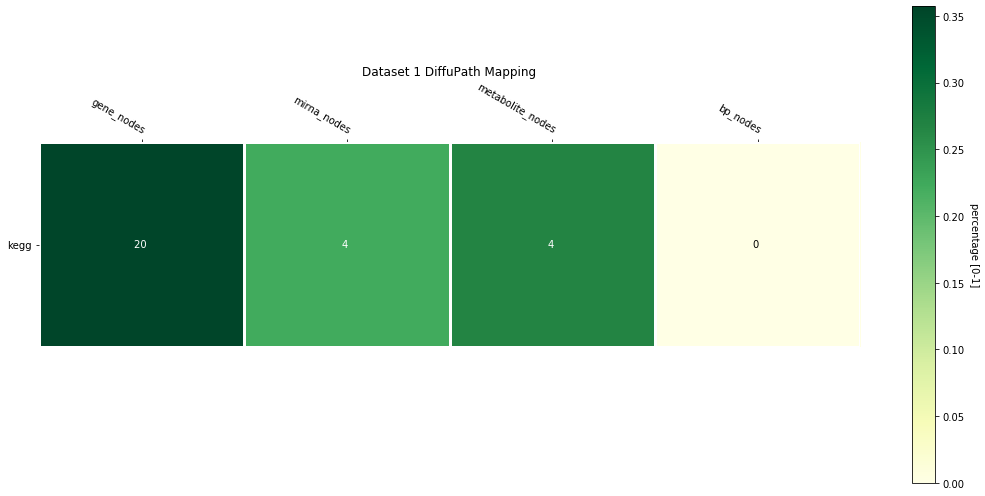

In [25]:
count, percentage, db_labels, entity_labels  = get_count_and_labels_from_two_dim_dict(mapping_by_database_and_entity)

show_heatmap(count, percentage, db_labels, entity_labels)


## 4. Cross-validation

In [26]:
from diffupath.views import box_plot_from_dict, box_plot_from_two_dimension_dict
from diffupath.cross_validation import cross_validation_one_x_in

### 4.1. Random Scheme

#### 4.1.1.  By method

In [27]:
mapping_by_entity_sets = {entity:set_ent[0] for entity, set_ent in mapping_by_entity.items()}

In [28]:
#del mapping_by_entity['bps']

In [29]:
auroc_metrics_by_method = {}
auprc_metrics_by_method = {}

In [30]:
mapping_by_entity_sets

{'metabolite': {'choline', 'glutathione', 'hypoxanthine', 'taurine'},
 'genes': {'actb',
  'aldob',
  'apoa1',
  'apoa2',
  'apoc1',
  'apoc3',
  'apoe',
  'apoh',
  'c1r',
  'c3',
  'ces1',
  'eef1a1',
  'fgg',
  'fut6',
  'mt1a',
  'mt2a',
  'plg',
  'serpina1',
  'tymp',
  'ubc'},
 'micrornas': {'mir122', 'mir21', 'mir29a', 'mir451a'},
 'pathway': set()}

In [ ]:
auroc_metrics_by_method['raw'], auprc_metrics_by_method['raw'], scores_raw = cross_validation_one_x_in(mapping_by_entity_sets, background_mat, k = 1, missing_value = 0)


In [ ]:
auroc_metrics_by_method['ml'], auprc_metrics_by_method['ml'], scores_ml = cross_validation_one_x_in(mapping_by_entity_sets, background_mat, k = 1, rows_unlabeled = True)


In [ ]:
auroc_metrics_by_method['z /ml'], auprc_metrics_by_method['z /ml'], scores_z = cross_validation_one_x_in(mapping_by_entity_sets, background_mat, k = 1, rows_unlabeled = True, z = True)


In [ ]:
auroc_metrics_by_method['z /raw'], auprc_metrics_by_method['z /raw'], scores_z = cross_validation_one_x_in(mapping_by_entity_sets, background_mat, k = 1, rows_unlabeled = False, z = True)


In [ ]:
def subvert_two_dim_dict(d):
    d2 = defaultdict(dict)
    for k1, v1 in d.items():
        for k2, v2 in v1.items():
            d2[k2][k1] = v2

    return dict(d2)

In [ ]:
s_auroc_metrics_by_method = subvert_two_dim_dict(auroc_metrics_by_method)
s_auprc_metrics_by_method = subvert_two_dim_dict(auprc_metrics_by_method)

In [ ]:
box_plot_from_two_dimension_dict(s_auroc_metrics_by_method['genes'], 'Genes', 'AUROC')

In [ ]:
box_plot_from_two_dimension_dictr(s_auroc_metrics_by_method['metabolite'], 'Metabolites', 'AUROC')

In [ ]:
box_plot_from_two_dimension_dictr(s_auroc_metrics_by_method['micrornas'], 'Mirnas', 'AUROC')

In [ ]:
box_plot_from_two_dimension_dictr(s_auprc_metrics_by_method['micrornas'], 'Mirnas', 'AUPRC')

In [ ]:
box_plot_from_two_dimension_dictr(s_auprc_metrics_by_method['metabolite'], 'Metabolite', 'AUPRC')

In [ ]:
box_plot_from_two_dimension_dictr(s_auprc_metrics_by_method['genes'], 'Genes', 'AUPRC')

In [ ]:
scores_genes_micrornas = scores_raw['genes']['micrornas'][0].order_rows(reverse=True, col_ref_idx = 0)
scores_micrornas_genes = scores_raw['micrornas']['genes'][0].order_rows(reverse=True, col_ref_idx = 1)
scores_micrornas_metabolite = scores_raw['micrornas']['metabolite'][0].order_rows(reverse=True, col_ref_idx = 1)

In [ ]:
print(scores_genes_micrornas)

In [ ]:
print(scores_micrornas_genes)

In [ ]:
box_plot_from_dict(auroc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUROC')

In [ ]:
box_plot_from_dict(auprc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUROC')

#### 5.1.2.  By entity

In [ ]:
auroc_metrics_by_entity, auprc_metrics_by_entity = cross_validation_by_subset_same_diff_input(mapping_by_entity, background_mat, k = 10)


In [ ]:
box_plot_from_dict(auroc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUROC')


In [ ]:
box_plot_from_dict(auprc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUPRC')

### 5.2. Leave Two Omics Out (LTOO)

In [ ]:
mapping_by_db

In [ ]:
auroc_metrics_by_db, auprc_metrics_by_db = cross_validation_one_x_in_disjoint(mapping_by_db,
                                                                              disjoint = True,
                                                                              background_mat, 
                                                                              k = 1)

In [ ]:
box_plot_from_dict(auroc_metrics_by_entity, 'Leave Two DB Out Validation', 'DB', 'AUROC')